<h2>Neurala CAFFE Training Workspace for SNIPER
This block of code does the importing of files</h2>

In [2]:
# This block of code does the importing

# We can ignore the numpy size difference warnings that come up because of
#  differences in numpy and matplotlib versions
#import warnings
#warnings.filterwarnings("ignore", message="numpy.dtype size changed")
#warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

#from ConfigParser import SafeConfigParser
from PIL import Image, ExifTags

#import pynemo
import multiprocessing
import scipy.ndimage
import numpy as np
%matplotlib inline
from pylab import *
import caffe
#import h5py
import time
import cv2
import os

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math

#sys.path.append('utils')
from utils.TrainNet import train, trainXSteps
from utils.Vis import vis_make_palette, vis_color_seg, checkEXIFRotation

# caffe.set_mode_cpu()
# print("CPU mode")

caffe.set_mode_gpu()
caffe.set_device(0)
print("GPU mode")

print('OK')

GPU mode
OK


<h3>Global Variables we'll use</h3>

In [3]:
# fixed square size to all images
# Didn't understand this block!!!!!!!!!

CONST_IMG_SIZE = 512
CONST_IMG_DIMS = 3 # set to 3 for non-masktrack / normal training

TRAIN_TOTALSTEPS = 800
TRAIN_SOLVER_STEPS = 10
TRAIN_EPOCHS_TO_AVG_OVER = 100  #iterations averaged over are this * solver_steps
TRAIN_INITIAL_STEPS = 100

<H3>Read in the directories from a file</H3>

In [4]:
# Train with the SNIPER custom python layers
TRAIN_FOLDER_TO_SAVE_MODEL = '/opt/caffe/neurala/training-pipeline/models/Example/training/'

# TRAIN_SOLVER = "/opt/caffe/neurala/training-pipeline/models/Example/Solver_GorchNet_Updated.prototxt"
# TRAIN_SOLVER = "/opt/caffe/neurala/training-pipeline/models/MayTraining/DenseNet/solver_RPN.prototxt"

# Below was the original one
TRAIN_SOLVER = "/opt/caffe/neurala/training-pipeline/models/FullDenseNet/Solver_FullDenseNet-Total.prototxt"

# Layer for custom input
# TRAIN_SOLVER = "/opt/caffe/neurala/training-pipeline/models/FullDenseNet/Solver_FullDenseNet-Custom.prototxt"


print(TRAIN_SOLVER)   # Location of the caffe .solver file, used for training
print(TRAIN_FOLDER_TO_SAVE_MODEL)  # Where we want to save training snapshots to
print('')

/opt/caffe/neurala/training-pipeline/models/FullDenseNet/Solver_FullDenseNet-Total.prototxt
/opt/caffe/neurala/training-pipeline/models/Example/training/



<h2>Create a solver</h2>
'If you want a new model from scratch, just create the solver.<br>
If you want to load it with a pretrained network, run both blocks of code<br>
NOTE: In order to run these code blocks you'll need an already made HDF5 dataset.<br>
For that, scroll down to creating HDF5 datasets

In [5]:

# In order to load a model for training, we need to load the train_val prototext
# That means if we loaded a `net` for testing, we should remove it from memory before trying to load
# a second Caffe network (unless your GPU has enough RAM to load multiple Caffe models)
# net = None
# Create a new Solver
import caffe

solver = caffe.get_solver(TRAIN_SOLVER)

"""
There are two ways to define a solver

solver = caffe.get_solver(TRAIN_SOLVER) // Here you define the type in the protext file
    

solver = caffe.SGDSolver(TRAIN_SOLVER)


The contents of the protext file are:

test_iter: 100
test_interval: 500
base_lr: 0.001
display: 100
max_iter: 300000
lr_policy: "fixed"
gamma: 0.5
momentum: 0.9
weight_decay: 0.0001
snapshot: 10000
snapshot_prefix: "snapshot"
solver_mode: GPU
random_seed: 4321
net: "/opt/caffe/neurala/training-pipeline/models/FullDenseNet/FullDenseNet-Total.prototxt"
solver_type: SGD
iter_size: 4
"""

"""
test_iter: 100
test_interval: 500
base_lr: 0.001
display: 100
max_iter: 300000
lr_policy: "fixed"
gamma: 0.5
momentum: 0.9
weight_decay: 0.0001
snapshot: 10000
snapshot_prefix: "snapshot"
solver_mode: GPU
random_seed: 4321
net: "/opt/caffe/neurala/training-pipeline/models/FullDenseNet/FullDenseNet-Total.prototxt"
solver_type: SGD
iter_size: 4

"""


'\ntest_iter: 100\ntest_interval: 500\nbase_lr: 0.001\ndisplay: 100\nmax_iter: 300000\nlr_policy: "fixed"\ngamma: 0.5\nmomentum: 0.9\nweight_decay: 0.0001\nsnapshot: 10000\nsnapshot_prefix: "snapshot"\nsolver_mode: GPU\nrandom_seed: 4321\nnet: "/opt/caffe/neurala/training-pipeline/models/FullDenseNet/FullDenseNet-Total.prototxt"\nsolver_type: SGD\niter_size: 4\n\n'

In [6]:
# # Untrained PT
# solver.net.copy_from('/opt/caffe/neurala/training-pipeline/models/Example/snapshot_GorchNet.caffemodel')

# # March 26 Trained model
# solver.net.copy_from('/opt/caffe/neurala/training-pipeline/training/Mar26/snapshot_iter_307554.caffemodel')

# April2 Trained model
# solver.net.copy_from('/opt/caffe/neurala/training-pipeline/training/Apr3/snapshot_iter_283896.caffemodel')

# # April 5th training
# solver.net.copy_from('/opt/caffe/neurala/training-pipeline/training/Apr5/snapshot_iter_6170.caffemodel')

# April 8th training
# solver.net.copy_from('/opt/caffe/neurala/training-pipeline/training/Apr8/snapshot_iter_24680.caffemodel')
# solver.restore('/opt/caffe/neurala/training-pipeline/training/Apr9/snapshot_iter_6170.solverstate')

# Latest Gorchnet from Anatoly Apr10
# solver.net.copy_from('/opt/caffe/neurala/training-pipeline/models/Gorchnet/snapshot_iter_774039.caffemodel')

# # Apr12 Training that did not work
# solver.net.copy_from('/opt/caffe/neurala/training-pipeline/training/Apr12/snapshot_iter_12340.caffemodel')

# # April 16th training
# solver.restore('/opt/caffe/neurala/training-pipeline/training/Apr16/snapshot_iter_37020.solverstate')

# DenseNet model original
# solver.net.copy_from('/opt/caffe/neurala/training-pipeline/models/weights/snapshot_iter_40000.caffemodel')

# 300000 Forward pass model
solver.net.copy_from('/opt/caffe/neurala/training-pipeline/models/weights/snapshot_iter_300000.caffemodel')

"""
Loading caffemodel for finetuning with a particular solver can be obtained in Pycaffe by means of get_solver() 
and net.copy_from() functions:

solver=caffe.get_solver('prototxtfile.prototxt')
solver.net.copy_from('weights.caffemodel')

"""


"\nLoading caffemodel for finetuning with a particular solver can be obtained in Pycaffe by means of get_solver() \nand net.copy_from() functions:\n\nsolver=caffe.get_solver('prototxtfile.prototxt')\nsolver.net.copy_from('weights.caffemodel')\n\n"

In [7]:
# net = caffe.Net(str("/opt/caffe/neurala/training-pipeline/Jeff/May15/temp2.prototxt"),
#                 1)#, 
#                 #weights=str(TEST_CAFFEMODEL))
# net = caffe.Net(str("/opt/caffe/neurala/training-pipeline/Jeff/May15/FullDenseNet/FullDenseNet-Total.prototxt"),1)

net = solver.net

print(net)

<h3>Check out your model architecture</h3>

In [8]:
# Display the size of the image data as it transforms through the model
def displayModelArch(mySolver):
    display([(k, v.data.shape) for k, v in mySolver.net.blobs.items()])
    
# Display the weights that make up the model
def displayModelSize(mySolver):
    display([(k, v[0].data.shape) for k, v in mySolver.net.params.items()])
    
    # Display the size of the image data as it transforms through the model
def displayModelArch(myNet):
    display([(k, v.data.shape) for k, v in myNet.blobs.items()])
    
# Display the weights that make up the model
def displayModelSize(myNet):
    display([(k, v[0].data.shape) for k, v in myNet.params.items()])

In [9]:
# Test displayModelArch and displayModelSize
# Display Tensor Size
# displayModelArch(net)


In [10]:
# # Display Weight size
# displayModelSize(net)


In [11]:
labels = """background
person
bicycle
car
motorcycle
airplane
bus
train
truck
boat
traffic light
fire hydrant
stop sign
parking meter
bench
bird
cat
dog
horse
sheep
cow
elephant
bear
zebra
giraffe
backpack
umbrella
handbag
tie
suitcase
frisbee
skis
snowboard
sports ball
kite
baseball bat
baseball glove
skateboard
surfboard
tennis racket
bottle
wine glass
cup
fork
knife
spoon
bowl
banana
apple
sandwich
orange
broccoli
carrot
hot dog
pizza
donut
cake
chair
couch
potted plant
bed
dining table
toilet
tv
laptop
mouse
remote
keyboard
cell phone
microwave
oven
toaster
sink
refrigerator
book
clock
vase
scissors
teddy bear
hair drier
toothbrush"""

coco_classes = {i: v.replace(' ', '_') for i, v in enumerate(labels.split('\n'))}

print(coco_classes)


{0: 'background', 1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic_light', 11: 'fire_hydrant', 12: 'stop_sign', 13: 'parking_meter', 14: 'bench', 15: 'bird', 16: 'cat', 17: 'dog', 18: 'horse', 19: 'sheep', 20: 'cow', 21: 'elephant', 22: 'bear', 23: 'zebra', 24: 'giraffe', 25: 'backpack', 26: 'umbrella', 27: 'handbag', 28: 'tie', 29: 'suitcase', 30: 'frisbee', 31: 'skis', 32: 'snowboard', 33: 'sports_ball', 34: 'kite', 35: 'baseball_bat', 36: 'baseball_glove', 37: 'skateboard', 38: 'surfboard', 39: 'tennis_racket', 40: 'bottle', 41: 'wine_glass', 42: 'cup', 43: 'fork', 44: 'knife', 45: 'spoon', 46: 'bowl', 47: 'banana', 48: 'apple', 49: 'sandwich', 50: 'orange', 51: 'broccoli', 52: 'carrot', 53: 'hot_dog', 54: 'pizza', 55: 'donut', 56: 'cake', 57: 'chair', 58: 'couch', 59: 'potted_plant', 60: 'bed', 61: 'dining_table', 62: 'toilet', 63: 'tv', 64: 'laptop', 65: 'mouse', 66: 'remote', 67: 'keyboard', 68: 'cell_p

<h2>Train the Network</h2>
Run this next block in order to train the network

In [12]:
# import time

# # Set the training parameters
# base_lr = 0.01
# momentum = 0.9
# weight_decay = 0.0005
# lr_w_mult = 1
# lr_b_mult = 2

# # Reset the SGD Momentum
# momentum_hist = {}
# for layer in solver.net.params:
#     try:
#         m_w = np.zeros_like(solver.net.params[layer][0].data)
#         m_b = np.zeros_like(solver.net.params[layer][1].data)
#     except:
#         m_w = 1
#         m_b = 1
#     momentum_hist[layer] = [m_w, m_b]

In [13]:
# # Used in the next cell to time how long it takes to train one image

def getshape(obj):
    try:
        result = obj.shape
    except AttributeError:
        try:
            result = len(obj)
        except TypeError:
            result = 0
    return result

# def getTimeStr(end, start):
#     if end - start > 100:
#         mins = int((end - start) / 60)
#         secs = ((end - start) % 60) - mins
#         return (str(mins) + "m " + "{0:.3f}".format(secs) + "s")
#     else: 
#         return ("{0:.3f}".format(end - start) + "s")
    
# def printBlobData(mystr):
#     l_idx = list(solver.net._layer_names).index(mystr)
#     tops = [(solver.net._blob_names[bi], solver.net.blobs[solver.net._blob_names[bi]].data)
#             for bi in list(solver.net._top_ids(l_idx))]
#     for item, val in tops:
#         print(f'{item} : maxValue {max(val.flatten())}')
# #         print(f'{item} : maxValue {max(val.flatten())}\nshape {getshape(val)}')
    
# def trainXSteps(x):
#     solver.step(x)
#     l_idx = list(solver.net._layer_names).index('SniperDataLayer')
#     tops = [(solver.net._blob_names[bi], solver.net.blobs[solver.net._blob_names[bi]].data)
#             for bi in list(solver.net._top_ids(l_idx))]
# #     print(tops)
# #     for tn in tops:
# #         print(f"output name {tn} has shape {solver.net.blobs[tn].data.shape}")
#     print("Blob Information:")
#     for item, val in tops:
#         print(f'{item}: type {type(val)} ' +
#               f'; shape {getshape(val)} ' +
#               f'; maxValue {max(val.flatten())} ')# +
# #               f'; maxValIndex {val.argmax(axis=0)}' +
# #               f'; Val at maxIndex {val[val.argmax(axis=0)]}' +
#               #f'; value {val} ')
        
#     print()
# #     l_idx = list(solver.net._layer_names).index('conv1')
# #     tops = [(solver.net._blob_names[bi], solver.net.blobs[solver.net._blob_names[bi]].data)
# #             for bi in list(solver.net._top_ids(l_idx))]
# #     print("Blob Information:")
# #     for item, val in tops:
# #         print(f'{item} : maxValue {max(val.flatten())} ; shape {getshape(val)}')
# # #         print(f'{item}: type {type(val)} \n' +
# # #               f'; shape {getshape(val)} \n' +
# # # #               f'; value {val} ' +
# # #               f'; maxValue {max(val.flatten())} \n' +
# # #               f'; maxValIndex {np.where(val.flatten() == max(val.flatten()))}')
#     printBlobData('cascade64/1')
#     printBlobData('cascade64/3x1_3')
#     printBlobData('cascade96/1x3_1')
#     printBlobData('cascade128/1x3_2')
#     printBlobData('cascade160/1x3_3')
#     printBlobData('cascade224/1x3_3')
#     printBlobData('cascade256/1x3_3')
#     printBlobData('cascade256/1x3_4')
#     printBlobData('cascade256/output')
#     printBlobData('rpn_conv/3x3')
#     printBlobData('conv_new_1')
#     printBlobData('fc_new_1')
#     printBlobData('fc_new_2')
    
#     printBlobData('cls_score')
#     printBlobData('bbox_preds')
    
#     printBlobData('rpn_labels_reshape')
#     printBlobData('rpn_cls_score')
#     printBlobData('rpn_bbox_weights_reshape')
#     print("###################################")
#     printBlobData('rpn_bbox_pred')
# #     printBlobData('rpn_bbox_pred_x_rpn_bbox_weights')
#     printBlobData('rpn_bbox_loss')
    
#     return solver.net.blobs['bbox_loss']

In [14]:
# solver.solve()
# solver.step(1)

In [15]:
# for ii in range(1000):
#     solver.step(100)
# solver.step(1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The shape of data is  (6, 3, 512, 512)
The shape of data blob is  (3, 512, 512)
The shape of im3 is (512, 512, 3)
The shape of in_temp is: (3, 512, 512, 3)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
The shape of the rpn_label is  (6, 1024)
The shape of the rpn_bbox_pred is  (6, 84, 32, 32)
The shape of the gt_boxes is  (6, 100, 5)
The shape of the rpn_cls_score is  (6, 22, 32, 32)
The shape of the rpn_bbox_weights is  (6, 84, 32, 32)
The shape of the rpn_bbox_targets is  (6, 84, 32, 32)


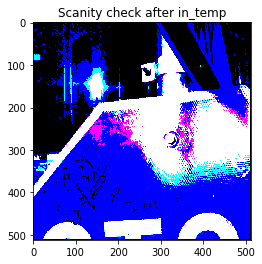

In [17]:
def checkEXIFRotation(image):
    try:  #see if we have an exif orientation tag
        for orientation in ExifTags.TAGS.keys():

            if ExifTags.TAGS[orientation]!='Orientation':
                continue

            exif=dict(image._getexif().items())

            if exif[orientation] == 3:
                rotate_mask = 3
            elif exif[orientation] == 6:
                rotate_mask = 6
            elif exif[orientation] == 8:
                rotate_mask = 8
            else:
                rotate_mask = 1
    except (AttributeError, KeyError, IndexError, ValueError):    
        #e.g., image doesn't have getexif   
        rotate_mask = -1

    return rotate_mask  #1,3,6,8,-1

def get_model_output(imagepath, prevLabel=None):
    # image agumentation
    
    # load image, switch to BGR, subtract mean, and make dims C x H x W for Caffe
    im_orig = Image.open(imagepath)
    print(imagepath)
    #print(Image.open(imagepath))
    im_orig.show()
#     print(f"np.array(im_orig) {np.array(im_orig)}")
#     print(f"np.array(im_orig, dtype=np.float32) {np.array(im_orig, dtype=np.float32)}")
#     print(f"np.array(im_orig, dtype=np.uint8) {np.array(im_orig, dtype=np.uint8)}")
    
    rotate_mask = checkEXIFRotation(im_orig) 

    if (rotate_mask == 3):
        im_orig=im_orig.rotate(180, expand=True)
    elif (rotate_mask == 6):
        im_orig=im_orig.rotate(270, expand=True)
    elif (rotate_mask == 8):
        im_orig=im_orig.rotate(90, expand=True)
        
    mySize = im_orig.size
    im = im_orig.resize((CONST_IMG_SIZE,CONST_IMG_SIZE), Image.ANTIALIAS)
    im.show()
#     print(f"np.array(im) {np.array(im)}")
#     print(f"np.array(im, dtype=np.float32) {np.array(im, dtype=np.float32)}")
#     print(f"np.array(im, dtype=np.uint8) {np.array(im, dtype=np.uint8)}")
    in_tmp = np.array(im, dtype=np.float32)

    print(f"in_tmp {in_tmp}")
    # catch Black and White Image errors
    try:
        in_tmp = in_tmp[:,:,::-1]
    except:
        print('error')
        return
    in_tmp = in_tmp.transpose((2,0,1))
    print(f"in_tmp {in_tmp}")

    # set up the data to be sent to the model, add the image
    im_info = np.zeros(shape=[1,3])
    im_info[0][:] = [512, 512, 1.667]
    
    # shape for input (data blob is N x C x H x W), set data
    net.blobs['im_info'].reshape(*im_info.shape)
    net.blobs['im_info'].data[0] = im_info
    
    # set up the data to be sent to the model, add the image
    valid_ranges = np.zeros(shape=[1,2])
    valid_ranges[0][:] = [96, 450]
    
    # shape for input (data blob is N x C x H x W), set data
    net.blobs['valid_ranges'].reshape(*valid_ranges.shape)
    net.blobs['valid_ranges'].data[0] = valid_ranges
    
    # set up the data to be sent to the model, add the image
    in_ = np.zeros(shape=[1,CONST_IMG_DIMS,CONST_IMG_SIZE,CONST_IMG_SIZE])
    in_[0][0:2] = in_tmp
    
    # shape for input (data blob is N x C x H x W), set data
    net.blobs['data'].reshape(*in_.shape)
    net.blobs['data'].data[0] = in_
    
    # run net and take argmax for prediction
    net.forward()
    net.blobs['data'].reshape(*in_.shape)
    net.blobs['data'].data[:] = in_
    rois_reshape = net.blobs['rois_reshape'].data
    bbox_preds = net.blobs['bbox_preds'].data
    cls_score_SOFTMAX = net.blobs['cls_score_SOFTMAX'].data
    rpn_bbox_pred = net.blobs['rpn_bbox_pred'].data
    rpn_cls_prob_reshape = net.blobs['rpn_cls_prob_reshape'].data

    return(rpn_bbox_pred, rois_reshape, bbox_preds, cls_score_SOFTMAX, rpn_cls_prob_reshape)

def get_model_input():
    """
    The images in the dataset are flipped left-right ONLY and not up-down
    """
    net.forward()
    #---------------------------------------------------------------------------------------------------------------#
    # This is where we are loading our the data
    #---------------------------------------------------------------------------------------------------------------#
    imageData = net.blobs['data'].data
    print("The shape of data is ",imageData.shape)
    print("The shape of data blob is ",net.blobs['data'].data[0].shape)
#     print("The shape of data is ",net.blobs['data'].data[0])

    in_temp = [imageData[0].transpose((1,2,0)), imageData[1].transpose((1,2,0)), imageData[2].transpose((1,2,0))]
    """
    Now let's try to display this ship
    """    
    im3 = in_temp[0]
    print("The shape of im3 is", np.shape(im3))
#     im3 = im3.transpose((1,2,0))
    fig5,ax5 = plt.subplots(1)
    plt.title("Scanity check after in_temp")
    ax5.imshow(im3)
    """
    The experimental code ends 
    """
    
    print("The shape of in_temp is:", np.shape(in_temp))
    data = []
    for temp in in_temp:
        print(type(temp))
        temp += 118
        temp[temp > 255] = 255
        temp[temp < 0] = 0 
        data.append(cv2.cvtColor(temp, cv2.COLOR_BGR2RGB))
    rpn_cls_score = net.blobs['softmax'].data
    rpn_labels = net.blobs['rpn_labels'].data
    rpn_bbox_pred = net.blobs['rpn/outputBoxes'].data
    rpn_bbox_weights = net.blobs['rpn_bbox_weights'].data
    rpn_bbox_targets = net.blobs['rpn_bbox_targets'].data
    gt_boxes = net.blobs['gt_boxes'].data
    print("The shape of the rpn_label is ", np.shape(rpn_labels))
    print("The shape of the rpn_bbox_pred is ", np.shape(rpn_bbox_pred))
    print("The shape of the gt_boxes is ", np.shape(gt_boxes))
    print("The shape of the rpn_cls_score is ", np.shape(rpn_cls_score))
    print("The shape of the rpn_bbox_weights is ", np.shape(rpn_bbox_weights))
    print("The shape of the rpn_bbox_targets is ", np.shape(rpn_bbox_targets))
    return(data,
           rpn_cls_score,
           rpn_labels,
           rpn_bbox_pred,
           rpn_bbox_weights,
           rpn_bbox_targets,
           gt_boxes)
tmpData = get_model_input()


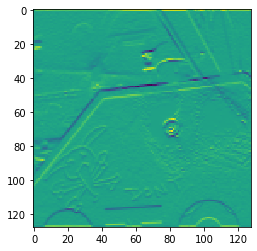

In [18]:
plt.imshow(net.blobs['conv1'].data[0,0,:,:])

In [19]:
# gt_boxes[2]

In [20]:
from copy import deepcopy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The shape of data is  (6, 3, 512, 512)
The shape of data blob is  (3, 512, 512)
The shape of im3 is (512, 512, 3)
The shape of in_temp is: (3, 512, 512, 3)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
The shape of the rpn_label is  (6, 1024)
The shape of the rpn_bbox_pred is  (6, 84, 32, 32)
The shape of the gt_boxes is  (6, 100, 5)
The shape of the rpn_cls_score is  (6, 22, 32, 32)
The shape of the rpn_bbox_weights is  (6, 84, 32, 32)
The shape of the rpn_bbox_targets is  (6, 84, 32, 32)


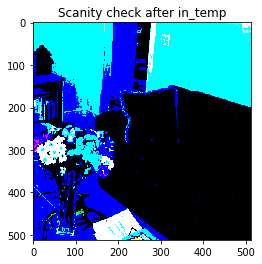

In [21]:
tmpData = get_model_input()
# myImagePath = "/opt/caffe/neurala/training-pipeline/models/Example/bread.jpg"
# myImagePath = "/opt/caffe/neurala/training-pipeline/models/Example/people_flower_ocean_sky_1.jpg"
# out = get_model_output(myImagePath)

In [22]:
tmpData[2].shape

(6, 1024)

In [23]:
out = deepcopy(tmpData)
myData = out[0]
rpn_cls_score = out[1]
rpn_labels = out[2]
rpn_bbox_pred = out[3]
# print(np.shape(rpn_bbox_pred))
rpn_bbox_weights = out[4]
rpn_bbox_targets = out[5]
gt_boxes = out[6]

# myIndex is the particular 1-21 index; x & y are the location in the 32x32 grid; tmp_rpn_bbox_mod use to get the x y 
# movements, and width and height adjustments
def index22_to_proposalbox(myIndex,x,y, tmp_rpn_bbox_mod):
    
    # if 0 it predicts no box
    if myIndex <= 0:
        return None
    
    mytmp_index = (myIndex-1) * 4
    
    
    ANCHOR_SCALES = [1, 3, 7, 11, 17, 23, 29]
    ANCHOR_RATIOS = [0.5, 1, 2]
    ANCHOR_RATIOS_Y = [math.sqrt(0.5), 1, math.sqrt(2)]
    ANCHOR_RATIOS_X = [math.sqrt(2), 1, math.sqrt(0.5)]
    
    # return to 0-20 (was 0-20 and anchors were 1-21)
    myIndex -= 1
    
    scale = myIndex%7
    box = math.floor(myIndex/7)
    
    ## We want the reverse of this
    # where we inputted:
    # gt_ctr_x
    # gt_ctr_y
    # gt_widths
    # gt_heights
    #
    # and we got as output
    # targets_dx
    # targets_dy
    # targets_dw
    # targets_dh
    
    # OG Code:
    #     targets_dx = (gt_ctr_x - ex_ctr_x) / (ex_widths + 1e-7)
    #     targets_dy = (gt_ctr_y - ex_ctr_y) / (ex_heights + 1e-7)
    #     targets_dw = np.log(gt_widths / (ex_widths + 1e-7))
    #     targets_dh = np.log(gt_heights / (ex_heights + 1e-7))
    
    # That means the inverse is:
    #     gt_ctr_x = (targets_dx * ex_widths) + ex_ctr_x
    #     gt_ctr_y = (targets_dy * ex_heights) + ex_ctr_y
    #     gt_widths = (10**targets_dw) * ex_widths
    #     gt_heights = (10**targets_dh) * ex_heights
    

    targets_dx = tmp_rpn_bbox_mod[0][mytmp_index+0][y][x]
    targets_dy = tmp_rpn_bbox_mod[0][mytmp_index+1][y][x]
    targets_dw = tmp_rpn_bbox_mod[0][mytmp_index+2][y][x]
    targets_dh = tmp_rpn_bbox_mod[0][mytmp_index+3][y][x]
    
    ex_ctr_x = (x * 16) + 8
    ex_ctr_y = (y * 16) + 8
    ex_widths = 16 * ANCHOR_SCALES[scale] * ANCHOR_RATIOS_X[box]
    ex_heights = 16 * ANCHOR_SCALES[scale] * ANCHOR_RATIOS_Y[box]
    
    gt_ctr_x = ((targets_dx * ex_widths) + ex_ctr_x)
    gt_ctr_y = ((targets_dy * ex_heights) + ex_ctr_y)
    gt_widths = (math.exp(targets_dw)) * (ex_widths)
    gt_heights = (math.exp(targets_dh)) * (ex_heights)
    
    xCenter = gt_ctr_x
    yCenter = gt_ctr_y
    width = gt_widths
    height = gt_heights

    xmin = xCenter - (width / 2)
    ymin = yCenter - (height / 2)
    xmax = xCenter + (width / 2)
    ymax = yCenter + (height / 2)
    
    # 1 - non-object score
    return [xmin, ymin, xmax, ymax, (1-rpn_cls_score[0][0][y][x])]

    # anchor object score
    # return [xmin, ymin, xmax, ymax, (rpn_cls_score[0][myIndex][y][x])]

# xmin ymin xmax ymax
def IOUCalc(boxes, query_boxes):
    """
    determine overlaps between boxes and query_boxes
    :param boxes: n * 5 bounding boxes (4 + 1 for objectness)
    :param query_boxes: k * 5 bounding boxes (4 + 1 for objectness)
    :return: overlaps: n * k overlaps
    """
    n_ = boxes.shape[0]
    k_ = query_boxes.shape[0]
    overlaps = np.zeros((n_, k_), dtype=np.float)
    for k in range(k_):
        query_box_area = (query_boxes[k, 2] - query_boxes[k, 0] + 1) * (query_boxes[k, 3] - query_boxes[k, 1] + 1)
        for n in range(n_):
            iw = min(boxes[n, 2], query_boxes[k, 2]) - max(boxes[n, 0], query_boxes[k, 0]) + 1
            if iw > 0:
                ih = min(boxes[n, 3], query_boxes[k, 3]) - max(boxes[n, 1], query_boxes[k, 1]) + 1
                if ih > 0:
                    box_area = (boxes[n, 2] - boxes[n, 0] + 1) * (boxes[n, 3] - boxes[n, 1] + 1)
                    all_area = float(box_area + query_box_area - iw * ih)
                    overlaps[n, k] = iw * ih / all_area
    return overlaps


def NMScalc(proposedBox, listOfPreviousBoxes, NMSthreshold=.75):
    # check if the proposed box overlaps with any of the list of previous boxes
    # if they do, check the objecteness score
    # if the proposed box has a higher objectness score, remove all of the overlapping boxes,
    #  and add the proposed box
    # If not, don't add the proposed box
    
    # If there are no previous boxes to overlap to, add the proposed box
    if len(listOfPreviousBoxes) == 0:
        return True
    
    # Calculate the IOU overlap between the proposed box and all previous boxes
    overlapArray = IOUCalc(np.array([proposedBox]),np.array(listOfPreviousBoxes))[0]
    # Filter the list out so we have a list of heavily overlapping previous boxes
    list_of_overlapping_previous_box_indices = np.nonzero(overlapArray > NMSthreshold)[0]
    
    # If there are no heavily overlapping boxes, then nbd, add the proposed box
    if len(list_of_overlapping_previous_box_indices) == 0:
        return True
    
    # set ourselves up to compare the objectness score between the proposed box
    #   and the heavily overlapping ones
    list_of_overlapping_previous_boxes = []
    for x in list_of_overlapping_previous_box_indices:
        list_of_overlapping_previous_boxes.append(listOfPreviousBoxes[x])
    list_of_overlapping_previous_boxes_objectnessScore = [box[4] for box in list_of_overlapping_previous_boxes]
    
    # If the proposed box has a higher objectness score than all other boxes it overlaps with,
    #   Then remove those other boxes
    #   Otherwise don't add this box (because the other boxes are better)
    if np.all(proposedBox[4] > list_of_overlapping_previous_boxes_objectnessScore):
        for index in sorted(list_of_overlapping_previous_box_indices, reverse=True):
            del listOfPreviousBoxes[index]
        return True
    
    return False

def calcAR(tmp_gtBoxes, tmp_proposedBoxes, ARThreshold=.75):
    # To calculate the average recall, we need to go through each of the GT boxes
    # and find the proposed box that overlaps with it greater than .75
    # If there is one, we increment our count of true positives
    #  and remove that overlapping proposed box from the list
    # If there isn't one, we increment our count of false negatives
    # then we count the number of proposed bounding boxes left over, that number is our count of false positives
    
    # so we don't directly modify the matrices
    gtBoxes = list(tmp_gtBoxes).copy()
    proposedBoxes = list(tmp_proposedBoxes).copy()
    
    numTruePositive = 0
    numFalsePositive = 0
    numFalseNegative = 0
    # numTrueNegative = infinity
    
    # For each of the GT Boxes
    for oneGTBox in gtBoxes:
        # if it's [-1, -1, -1, -1, -1] then skip
        if sum(oneGTBox) == -5:
            continue
        
        # calculate the IOU with all proposals
        overlapArray = IOUCalc(np.array([oneGTBox]),np.array(proposedBoxes))[0]
        # find the gtBoxes that have an overlap greater than .75
        list_of_overlapping_previous_box_indices = np.nonzero(overlapArray > ARThreshold)[0]
    
        # If there are no heavily overlapping boxes, then thats a gt that has no proposal,
        #  which is a false negative
        if len(list_of_overlapping_previous_box_indices) == 0:
            numFalseNegative += 1
            continue
        # else there is one, delete a random one (the first one) and count that as a true positive
        else:
            numTruePositive += 1
            del proposedBoxes[list_of_overlapping_previous_box_indices[0]]
            continue
    numFalsePositive = len(proposedBoxes)
    return (numTruePositive, numFalseNegative, numFalsePositive)
    
# model output
rpn_cls_score_softmax = rpn_cls_score[0].argmax(axis=0)
myProposedRects = []
# count = 0
for x in range(32):
    for y in range(32):
        chosenIndex = rpn_cls_score_softmax[y][x]
        tmpBox = index22_to_proposalbox(chosenIndex,x,y,rpn_bbox_pred)
        if tmpBox:
#             print(tmpBox)
            if NMScalc(tmpBox, myProposedRects, 0.3):
#                 print("in If")
#                 print(tmpBox)
#                 print("out If")
                myProposedRects.append(tmpBox)
#                 count +=1
#print("There are",count,"Rectangles in the model output")

# GT anchors without modification
rpn_labels_reshaped = rpn_labels[0].astype(int).reshape(-1, 32).transpose()
myGTRects = []
count = 0
for x in range(32):
    for y in range(32):
        chosenIndex = rpn_labels_reshaped[y][x]
        tmpBox = index22_to_proposalbox(chosenIndex,y,x,rpn_bbox_targets)
        if tmpBox:
#             print(tmpBox)
            if NMScalc(tmpBox, myGTRects, 0):
                myGTRects.append(tmpBox)
                count +=1
#                 print(tmpBox)
#                 print("appended")
print("There are",count,"Rectangles in the GT")

# print(myGTRects)
TP1, FN1, FP1 = calcAR(gt_boxes[0].tolist(), myProposedRects, 0.5)
TP2, FN2, FP2 = calcAR(myGTRects, myProposedRects, 0.5)



There are 7 Rectangles in the GT


total proposed bounding boxes = 5

COCO gt_boxes
total COCO gt_boxes = 5
TP:1, FN:4, FP:4
Precision = 0.2
Recall = 0.2

SNIPER gt_boxes
total SNIPER gt_boxes = 4
TP:1, FN:3, FP:4
Precision = 0.2
Recall = 0.25
There are 4 Rectangles in the GT


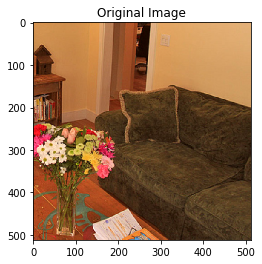

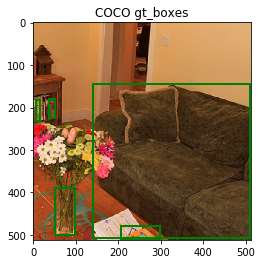

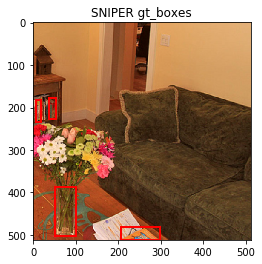

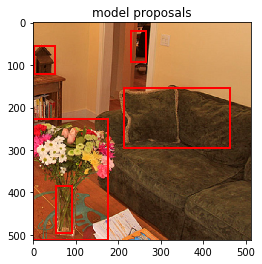

In [24]:
print(f"total proposed bounding boxes = {len(myProposedRects)}\n")
print("COCO gt_boxes")
print(f"total COCO gt_boxes = {int(len(gt_boxes[0][np.nonzero(gt_boxes[0] > -1)])/5)}")
print(f"TP:{TP1}, FN:{FN1}, FP:{FP1}")
print(f"Precision = {TP1/(TP1 + FP1 + 1e-70)}")
print(f"Recall = {TP1/(TP1 + FN1 + 1e-70)}\n")

print("SNIPER gt_boxes")
print(f"total SNIPER gt_boxes = {len(myGTRects)}")
print(f"TP:{TP2}, FN:{FN2}, FP:{FP2}")
print(f"Precision = {TP2/(TP2 + FP2 + 1e-70)}")
print(f"Recall = {TP2/(TP2 + FN2 + 1e-70)}")


                
img = np.array(myData[0], dtype=np.uint8)

fig1,ax1 = plt.subplots(1)
plt.title('Original Image')
ax1.imshow(img)

fig2,ax2 = plt.subplots(1)
plt.title('COCO gt_boxes')
ax2.imshow(img)

# Graph the gt_boxes
for i in range(100):
    rect = patches.Rectangle(
        (gt_boxes[0][i][0],gt_boxes[0][i][1]),
        gt_boxes[0][i][2]-gt_boxes[0][i][0],
        gt_boxes[0][i][3]-gt_boxes[0][i][1],
        linewidth=2,
        edgecolor='g',
        facecolor='none')
    ax2.add_patch(rect)
    if gt_boxes[0][i][0] == -1:
        break


fig4,ax4 = plt.subplots(1)
plt.title('SNIPER gt_boxes')
ax4.imshow(img)

# graph the actual GT boxes the model is trained on
ii = -1
count = 0
for tmpRect in myGTRects:
#     print(tmpRect)
    count+=1
    ii += 1
    rect = patches.Rectangle(
        (tmpRect[0],tmpRect[1]),
        tmpRect[2] - tmpRect[0],
        tmpRect[3] - tmpRect[1],
        linewidth=2,
        edgecolor='r',
        facecolor='none')
    ax4.add_patch(rect)
print("There are",count,"Rectangles in the GT")
    
fig3,ax3 = plt.subplots(1)
plt.title('model proposals')
ax3.imshow(img)

# graph the model output
ii = -1
for tmpRect in myProposedRects:
    ii += 1
    rect = patches.Rectangle(
        (tmpRect[0],tmpRect[1]),
        tmpRect[2] - tmpRect[0],
        tmpRect[3] - tmpRect[1],
        linewidth=2,
        edgecolor='r',
        facecolor='none')
    ax3.add_patch(rect)


In [25]:
import csv
import cv2
from PIL import ImageDraw, Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def get_cord(img_location, txt_location):
    img = Image.open(img_location)
    #img = img.resize((512,512))
    with open(txt_location, 'r') as f:
        reader = csv.reader(f, dialect='excel', delimiter='\t')
        cord = []
        cord_arr = np.zeros(4) 
        for row in reader:
            img_class = row[0]
            x_top = float(row[4])
            y_top = float(row[5])
            x_bottom = float(row[6])
            y_bottom = float(row[7])
    return x_top, y_top, x_bottom, y_bottom

# 	draw = ImageDraw.Draw(img)
# 	draw.rectangle(((x_top, y_top), (x_bottom, y_bottom)))
# 	print (img_class)
# 	img.show()


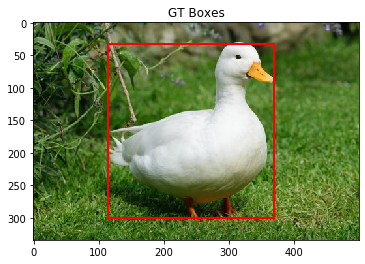

In [45]:
img_loc = '/opt/caffe/neurala/training-pipeline/models/FullDenseNet/04fd9f2d-0000000.jpg'
txt_loc = '/opt/caffe/neurala/training-pipeline/models/FullDenseNet/04fd9f2d-0000000.txt'
x_top, y_top, x_bottom, y_bottom = get_cord(img_loc, txt_loc)
img = Image.open(img_loc)
# img = cv2.imread(img_loc,0)
draw = ImageDraw.Draw(img)
draw.rectangle(((x_top, y_top), (x_bottom, y_bottom)))
fig5,ax5 = plt.subplots(1)
plt.title("GT Boxes")

# for tmpRect in myProposedRects:

rect = patches.Rectangle(
        (x_top,y_top),
        x_bottom - x_top,
        y_bottom - y_top,
        linewidth=2,
        edgecolor='r',
        facecolor='none')
ax5.add_patch(rect)

ax5.imshow(img)

plt.show()

In [30]:
print(np.shape(img))

img_input = np.zeros((1,3,116,116))

print(np.shape(img_input))

# for i in range(3):
#      img_input[:,i,:,:] = img.[np.newaxis,np.newaxis, :, :]


mySize = img.size
im = img.resize((CONST_IMG_SIZE,CONST_IMG_SIZE), Image.ANTIALIAS)
im.show()
#     print(f"np.array(im) {np.array(im)}")
#     print(f"np.array(im, dtype=np.float32) {np.array(im, dtype=np.float32)}")
#     print(f"np.array(im, dtype=np.uint8) {np.array(im, dtype=np.uint8)}")
in_tmp = np.array(im, dtype=np.float32)
print(np.shape(in_tmp))


(334, 500, 3)
(1, 3, 116, 116)
(512, 512, 3)


In [31]:
# New code here

In [32]:
from PIL import Image, ExifTags

#import pynemo
import multiprocessing
import scipy.ndimage
import numpy as np
%matplotlib inline
from pylab import *
import caffe
#import h5py
import time
import cv2
import os

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math

#sys.path.append('utils')
from utils.TrainNet import train, trainXSteps
from utils.Vis import vis_make_palette, vis_color_seg, checkEXIFRotation

# caffe.set_mode_cpu()
# print("CPU mode")

caffe.set_mode_gpu()
caffe.set_device(0)
print("GPU mode")

print('OK')

GPU mode
OK


In [33]:
def get_cord(txt_loc):
    cord = []
    with open(txt_loc, 'r') as f:
        reader = csv.reader(f, dialect='excel', delimiter='\t')		
        cord_arr = np.zeros(4) 
        for row in reader:
            """
            The below stuff is required if the a$$nuckle who created the bboxes txt file didn't tab delimit 
            but instead used spaces
            """
            if (len(row) == 1):
                row = row[0].split()
            img_class = row[0]
            cord.append(row[0])
            cord_arr[0] = float(row[4])
            cord_arr[1] = float(row[5])
            cord_arr[2] = float(row[6])
            cord_arr[3] = float(row[7])
            cord.append(cord_arr)
            cord_arr = np.zeros(4)
    f.close()
    return cord

def data_loader(path):
    """
    Function to load image locations, corresponding classes and BBoxes contained withing a list file

    return:
    A list with each individual image of the form
    [Image_location in str, Image_Class, BBox in []]
    """
    # Reference the directory of the GVDL folder
    img_loc = path + 'train.list'
    data = [] 
    with open(img_loc, 'r') as f:
        reader = csv.reader(f, dialect='excel', delimiter='\t')		
        for row in reader:
            # seperate test-case for COCO
            if (path[-5:-1] == 'COCO'):   
                text = row[0][0:5] + '-labels/' + row[0][-16:-3] + 'txt'
            # for VOC and GVDL-D
            else:
                text = row[0][0:6] + 'labels' + row[0][12:-3] + 'txt'
            cord = get_cord(path + text)
            data.append([path + row[0], cord])

    """ The following code is to verify the dataloader 
        Please give the index of the image file you want to load; the code will take care of the txt file
        To verify, give a particular index
    """
    print(len(data))
    return data

In [34]:
data = data_loader('/opt/caffe/neurala/training-pipeline/models/FullDenseNet/GVDL-D/')
#data = data_loader('/opt/caffe/neurala/training-pipeline/models/FullDenseNet/VOC/')
#data = data_loader('/opt/caffe/neurala/training-pipeline/models/FullDenseNet/COCO/')

131


In [35]:
CONST_IMG_SIZE = 512
CONST_IMG_DIMS = 3 # set to 3 for non-masktrack / normal training

TRAIN_TOTALSTEPS = 800
TRAIN_SOLVER_STEPS = 10
TRAIN_EPOCHS_TO_AVG_OVER = 100  #iterations averaged over are this * solver_steps
TRAIN_INITIAL_STEPS = 100